In [18]:
import scanpy as sc
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import scib
import os
import matplotlib.pyplot as plt
import pertpy as pt

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

Extension horovod.torch has not been built: /usr/local/lib/python3.10/dist-packages/horovod/torch/mpi_lib_v2.cpython-310-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still available.


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/__init__.py:42: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('pytorch_lightning')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
Global seed set to 0
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_ex

ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

To use sccoda or tasccoda please install ete3 with pip install ete3

In [2]:
import rpy2.robjects.packages as rpackages
from rpy2.robjects import r

utils = rpackages.importr('utils')
utils.install_packages('kBET')

kbet = rpackages.importr('kBET')

R[write to console]: Installing package into ‘/home/mahim/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)



# Batch correction: RxRx19b, HUVEC

For more information on the dataset please see: https://www.rxrx.ai/rxrx19b and https://github.com/theislab/batch_correction_cellpainting/blob/feat/rxrx1_huvec_exploration/data/rxrx19b/rxrx19b_overview.md <br>

* [I. Before integration](#before)
    * [A. Read in the data and identify the batch_key](#before_sub1)
    * [B. Find which metrics are applicable for this dataset](#before_sub2)
    * [C. Compute scIB metrics](#before_sub3)
* [II. Integration](#integrate)
    * [A. Harmony](#integrate_sub1)
    * [B. Scanorama](#integrate_sub2)
    * [C. scVI](#integrate_sub3)
    * [D. scanVI](#integrate_sub4)
    * [E. scGen](#integrate_sub5)
* [III. After integration](#after)
    * [A. Harmony: Compute scIB metrics](#after_sub1)
    * [B. Harmony: Before and after UMAP visualization](#after_sub2)
    * [C. Scanorama: Compute scIB metrics](#after_sub3)
    * [D. Scanorama: Before and after UMAP visualization](#after_sub4)  
    * [E. scVI: Compute scIB metrics](#after_sub5)
    * [F. scVI: Before and after UMAP visualization](#after_sub6) 
    * [G. scanVI: Compute scIB metrics](#after_sub7)
    * [H. scanVI: Before and after UMAP visualization](#after_sub8) 
    * [I. scGen: Compute scIB metrics](#after_sub9)
    * [J. scGen: Before and after UMAP visualization](#after_sub10) 

## I. Before integration  <a class="anchor" id="before"></a>

### A. Read in the data and identify the batch_key <a class="anchor" id="before_sub1"></a>

Read in the embeddings and add metadata to adata.obs:

In [ ]:
meta_file = "../../data/rxrx19b/metadata.csv"
embedding_file = "../../data/rxrx19b/embeddings.csv"
if not os.path.exists(meta_file):
    raise FileNotFoundError("Please download the metadata from https://www.rxrx.ai/rxrx19b and put the file metadata.csv in the directory data/rxrx19b")
if not os.path.exists(embedding_file):
    raise FileNotFoundError("Please download the embeddings from https://www.rxrx.ai/rxrx19b and put the file embeddings.csv in the directory data/rxrx19b")

In [ ]:
adata = sc.read_csv(embedding_file)
meta = pd.read_csv(meta_file, index_col = 0)
# change the order of the rows in the meta data to match the order in the embeddings
meta = meta.reindex(pd.read_csv(embedding_file, index_col = 0).index)
adata.obs = meta
# Replace NaN values with "blank" in a specific column
adata.obs['disease_condition'] = adata.obs['disease_condition'].fillna("blank")
adata.obs['plate'] = adata.obs['plate'].astype('category')
adata.obs['disease_condition'] = adata.obs['disease_condition'].astype('category')
print(adata)
meta.tail(n=5)

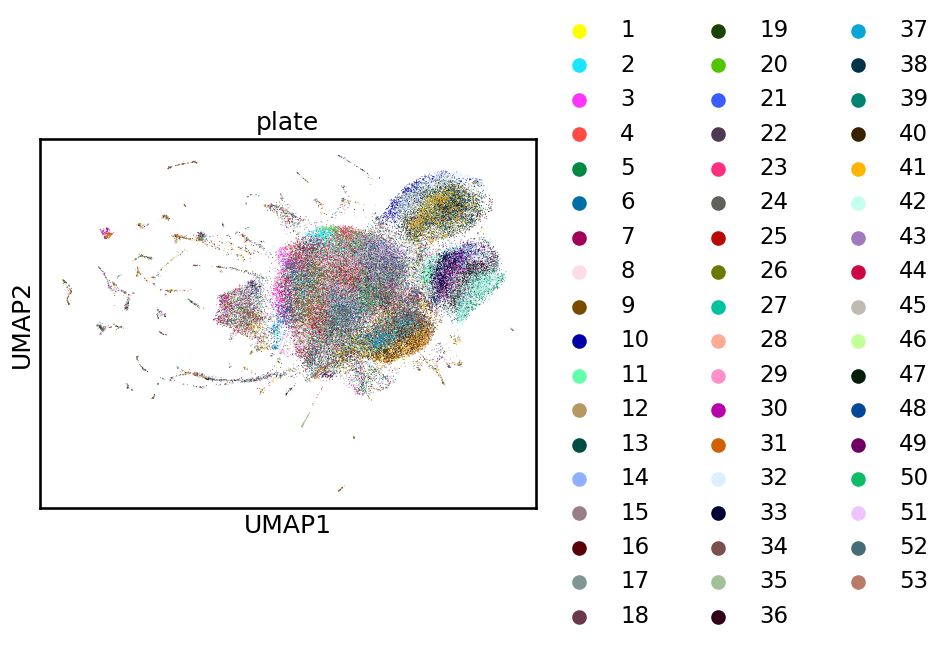

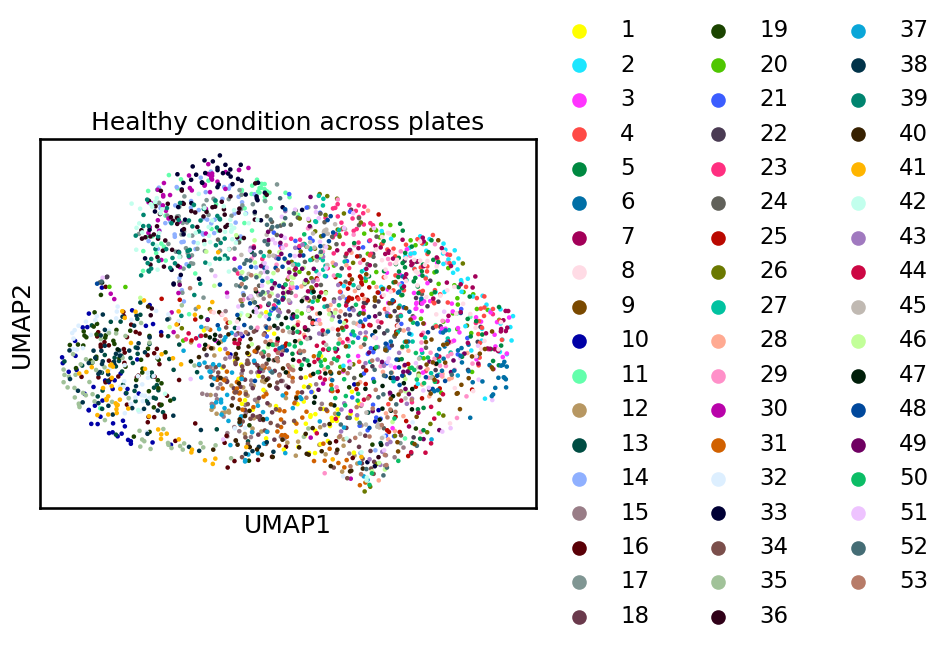

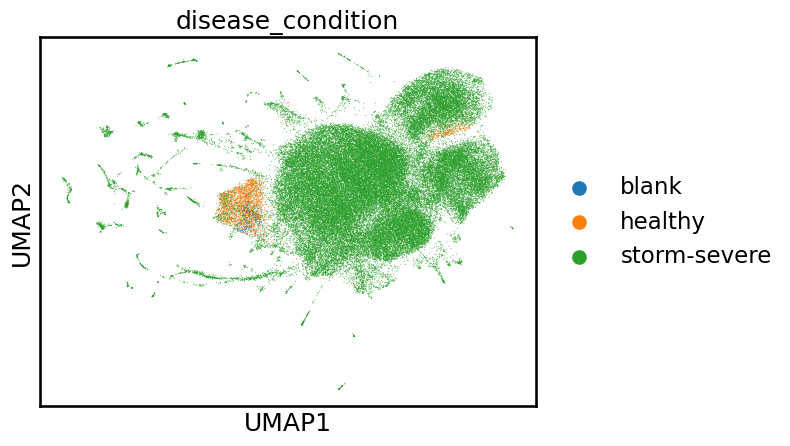

In [6]:
sc.pp.neighbors(adata, n_neighbors=15, use_rep = "X")
sc.tl.umap(adata)
sc.pl.umap(adata, color="plate")

healthy = adata[adata.obs["disease_condition"] == "healthy"]
sc.pp.neighbors(healthy, n_neighbors=15, use_rep = "X")
sc.tl.umap(healthy)
sc.pl.umap(healthy, color=["plate"], title = "Healthy condition across plates")

sc.pl.umap(adata, color="disease_condition")

We only have one experiment and one cell line in RxRx19b and have observed some inter-plate effects, therefore the batch_key will be "plate". The biology we want to conserve is "disease_condition" which we have also seen to cluster well.

### B. Find which metrics are applicable for this dataset<a class="anchor" id="before_sub2"></a>


The computed metrics for removal of batch effects are:

- Graph connectivity score 
- iLISI
- (kBET)
- PCR
- Silhouette batch 

Regarding kBET, it was not run as it kept killing the kernal session.
Regarding the PCR: this score is computed after integration once with the comparison (scib.metrics.pcr_comparison()) and once without the comparison (scib.metrics.pcr()).

The following biological conservation metrics are calculated:

- cLISI
- Silhouette biological
- NMI 
- ARI
- Isolated Label score F1
- Isolated Label score ASW

The isolated label score is also considered for this dataset, because in each batch, i.e. plate, we do not always have all labels. Specifically, only plate 53 has all three disease_conditions "blank", "healthy" and "storm-severe". Thus the label "blank" is only present in one batch, i.e. one plate.


Metrics excluded for this dataset are:

- Cell Cycle Conservation score
- HVG Overlap 
- Trajectory Conservation

We exclude the CCC, HVG Overlap and Trajectory Conservation score for this dataset, because we have image embeddings.

### C. Compute scIB metrics <a class="anchor" id="before_sub3"></a>

#### i. Batch correction metrics <a class="anchor" id="scIB_sub1"></a>

In [6]:
#Graph connectivity score
sc.pp.neighbors(adata, n_neighbors=15, use_rep = "X")
gc = scib.me.graph_connectivity(adata, label_key="disease_condition")

In [7]:
#iLISI
ilisi = scib.me.ilisi_graph(adata, batch_key="plate", type_="knn")

In [8]:
#kbet
#kbet = scib.me.kBET(adata, batch_key="plate", label_key="disease_condition", type_="knn")

In [9]:
#principal component regression, computes PCA if not provided: 
pcr_nc = scib.me.pcr(adata, covariate="plate")

In [10]:
#silhouette batch 
#only takes a slot in .obsm as input, i.e. embedding or pca -> compute PCA 
sc.pp.pca(adata, n_comps = 100)
silhouette_batch = scib.me.silhouette_batch(adata, batch_key="plate", label_key="disease_condition", embed="X_pca")

mean silhouette per group:               silhouette_score
group                         
healthy               0.944035
storm-severe          0.937636


#### ii. Biological conservation metrics <a class="anchor" id="scIB_sub2"></a>

In [11]:
#cell type lisi -> specify it as "knn"
clisi = scib.me.clisi_graph(adata, label_key="disease_condition", type_="knn")

In [12]:
#silhouette biological
silhouette = scib.me.silhouette(adata, label_key="disease_condition", embed="X_pca")

In [13]:
#NMI
# cluster_optimal_resolution uses precomputed knn if use_rep == None
nmi = scib.metrics.cluster_optimal_resolution(adata, label_key = "disease_condition",cluster_key = "cluster", metric = scib.me.nmi, return_all = True)[1]

resolution: 0.1, nmi: 0.16761560351007707
resolution: 0.2, nmi: 0.12245832624480608
resolution: 0.3, nmi: 0.10705869709798757
resolution: 0.4, nmi: 0.10474754121396418
resolution: 0.5, nmi: 0.1093822635726482
resolution: 0.6, nmi: 0.10629064473880698
resolution: 0.7, nmi: 0.10524969342244597
resolution: 0.8, nmi: 0.09991837711405764
resolution: 0.9, nmi: 0.10182682437310596
resolution: 1.0, nmi: 0.1009803700851034
resolution: 1.1, nmi: 0.09627924948601443
resolution: 1.2, nmi: 0.0925929960069622
resolution: 1.3, nmi: 0.08669984648357809
resolution: 1.4, nmi: 0.08691499949356431
resolution: 1.5, nmi: 0.08625754230382165
resolution: 1.6, nmi: 0.08471660022978668
resolution: 1.7, nmi: 0.08144269690565738
resolution: 1.8, nmi: 0.08287750200918895
resolution: 1.9, nmi: 0.08230243847838047
resolution: 2.0, nmi: 0.08257152809564865
optimised clustering against disease_condition
optimal cluster resolution: 0.1
optimal score: 0.16761560351007707


In [14]:
#ARI
# cluster_optimal_resolution uses precomputed knn if use_rep == None
ari = scib.metrics.cluster_optimal_resolution(adata, label_key = "disease_condition",cluster_key = "cluster", metric = scib.me.ari, return_all = True)[1]

resolution: 0.1, ari: 0.11992148940970221
resolution: 0.2, ari: 0.04772412096632188
resolution: 0.3, ari: 0.030631375084778416
resolution: 0.4, ari: 0.029705377107499296
resolution: 0.5, ari: 0.023619823105241276
resolution: 0.6, ari: 0.0212261725693167
resolution: 0.7, ari: 0.02039392782691741
resolution: 0.8, ari: 0.016210642999083535
resolution: 0.9, ari: 0.015994926117498583
resolution: 1.0, ari: 0.015663979045525436
resolution: 1.1, ari: 0.01362796069587396
resolution: 1.2, ari: 0.011704671953295975
resolution: 1.3, ari: 0.008863094276060336
resolution: 1.4, ari: 0.008928839244852577
resolution: 1.5, ari: 0.008399579874353974
resolution: 1.6, ari: 0.007479201850224946
resolution: 1.7, ari: 0.006247303211845533
resolution: 1.8, ari: 0.006697095568704332
resolution: 1.9, ari: 0.0064727203896102386
resolution: 2.0, ari: 0.006600099666566107
optimised clustering against disease_condition
optimal cluster resolution: 0.1
optimal score: 0.11992148940970221


In [15]:
#Isolated label score F1
isolated_label_F1 = scib.me.isolated_labels_f1(adata, batch_key="plate", label_key="disease_condition", embed = "X_pca")

isolated labels: no more than 1 batches per label
Compute neighbors on rep X_pca
blank: 0.14528249373782354


In [16]:
#Isolated label score ASW
isolated_label_ASW = scib.me.isolated_labels_asw(adata, batch_key="plate", label_key="disease_condition", embed="X_pca")

isolated labels: no more than 1 batches per label
blank: 0.5811349675059319


#### iii. Have a look at result <a class="anchor" id="scIB_sub3"></a>
Unintegrated results

1. Batch correction metrics

In [27]:
unintegrated_metrics = pd.DataFrame({"Unintegrated: Batch correction metrics": []})

unintegrated_metrics.loc["Graph_Conn"] = gc
unintegrated_metrics.loc["iLISI"] = ilisi
unintegrated_metrics.loc["PCR_NC"] = pcr_nc
unintegrated_metrics.loc["PCR_Comparison"] = None
#unintegrated_metrics.loc["kBET"] = kbet
unintegrated_metrics.loc["Silhouette_batch"] = silhouette_batch

unintegrated_metrics

,Unintegrated: Batch correction metrics
Graph_Conn,0.995098
iLISI,0.076178
PCR_NC,0.162428
PCR_Comparison,NaN
Silhouette_batch,0.940836


Graph connectivity score:
- Score range: ranges from 0 to 1.
- Meaning: measures the connectedness of cells within each batch after applying batch correction. A higher score closer to 1 indicates that the batch correction has successfully increased the connectivity and reduced the isolation of cells within each batch. It implies that cells within the same biological group or condition are more interconnected and grouped together, while cells from different batches are more separated.

iLISI:
- Score range: ranges from 0 to 1.
- Meaning: quantifies the consistency of local neighborhood relationships within and between batches. A higher iLISI score closer to 1 suggests better batch correction performance. It indicates that cells within the same batch have more consistent neighborhood relationships, resembling cells from the same biological condition, while cells from different batches have distinct neighborhood relationships.

kBET:
- Score range: ranges from 0 to 1.
- Meaning: assesses the batch effects in single-cell RNA-seq data. A score closer to 0 indicates strong batch effects, meaning that the variation between batches dominates the biological variation. A score closer to 1 indicates minimal batch effects, suggesting that the biological variation is the primary driver of the observed differences.

PCR:
- Score range: ranges from negative to positive values.
- Meaning: utilizes principal component analysis (PCA) to reduce the dimensionality of the data and perform regression analysis for batch correction. The score represents the performance of the regression model, where higher positive scores indicate better prediction accuracy and successful batch correction. Conversely, lower negative scores indicate poorer prediction accuracy and less effective batch correction.

Silhouette batch:
- Score range: ranges from -1 to 1.
- Meaning: measures the quality of batch correction by assessing the separation between cells from different batches. A higher silhouette batch score closer to 1 indicates better batch correction. It implies that cells within the same biological condition are well-separated from cells of other conditions, suggesting successful removal or reduction of batch effects. Conversely, a score closer to -1 indicates poor batch correction, where cells from different batches are not well-separated.

2. Biological conservation metrics

In [28]:
unintegrated_metrics_1 = pd.DataFrame({"Unintegrated: biol. conservation metrics": []})

unintegrated_metrics_1.loc["cLISI"] = clisi
unintegrated_metrics_1.loc["Silhouette"] = silhouette
unintegrated_metrics_1.loc["NMI"] = nmi
unintegrated_metrics_1.loc["ARI"] = ari
unintegrated_metrics_1.loc["Isolated_label_F1"] = isolated_label_F1
unintegrated_metrics_1.loc["Isolated_label_ASW"] = isolated_label_ASW

unintegrated_metrics_1

,Unintegrated: biol. conservation metrics
cLISI,1.000000
Silhouette,0.540424
NMI,0.167616
ARI,0.119921
Isolated_label_F1,0.145282
Isolated_label_ASW,0.581135


cLISI:
- Score range: ranges from 0 to 1.
- Meaning: quantifies the consistency of local neighborhood relationships of cell types within and between batches. A higher cLISI score closer to 1 suggests better batch correction performance. It indicates that the neighborhood relationships of cell types are more consistent within the same batch, resembling the biological structure, while being distinct from cell types in different batches.

Silhouette Biological:
- Score range: ranges from -1 to 1.
- Meaning: measures the quality of batch correction by evaluating the separation between different cell types or biological conditions. A higher silhouette biological score closer to 1 indicates better batch correction. It suggests that cells from the same biological condition are well-separated from cells of other conditions, indicating successful removal or reduction of batch effects. Conversely, a score closer to -1 indicates poor batch correction, where cell types or biological conditions are not well-separated.

NMI:
- Score range: ranges from 0 to 1.
- Meaning: quantifies the similarity between the clustering results of different batches or conditions. A higher NMI score closer to 1 suggests better batch correction. It indicates a high degree of similarity between the cluster assignments of cells within the same biological condition, reflecting successful batch effect removal. A score of 0 indicates no mutual information or similarity between the clusters.

ARI:
- Score range: ranges from -1 to 1.
- Meaning: measures the similarity between the cluster assignments of different batches or conditions, adjusted for chance. A higher ARI score closer to 1 indicates better batch correction. It suggests a high degree of similarity between the cluster assignments of cells within the same biological condition, reflecting successful batch effect removal. A score of 0 indicates the expected similarity by chance, while negative scores indicate dissimilarity.

Isolated Label Score F1:
- Score range: ranges from 0 to 1.
- Meaning: measures the preservation of cell type labels after batch correction. A higher F1 score closer to 1 indicates better preservation of cell type information. It suggests that the batch correction method has successfully maintained the cell type identities and avoided label changes across different batches.

Isolated Label Score ASW:
- Score range: ranges from -1 to 1.
- Meaning: measures the separation and compactness of cell type clusters after batch correction. A higher ASW score closer to 1 indicates better separation and compactness of cell type clusters. It suggests that cells of the same type form tight and well-separated clusters, indicating successful preservation of cell type information.

In [17]:
adata.write_h5ad(
    "rxrx19b_adata.h5ad",
    compression="gzip"
)

## II. Integration  <a class="anchor" id="integrate"></a>

### A. Harmony <a class="anchor" id="integrate_sub1"></a>

In [18]:
harmony = adata.copy()
scib.integration.harmony(harmony, batch = "plate")

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).


AnnData object with n_obs × n_vars = 70384 × 128
    obs: 'well_id', 'cell_type', 'experiment', 'plate', 'well', 'site', 'disease_condition', 'treatment', 'treatment_conc', 'SMILES', 'cluster', 'silhouette_temp'
    uns: 'neighbors', 'umap', 'plate_colors', 'disease_condition_colors', 'pca', 'leiden'
    obsm: 'X_umap', 'X_pca', 'X_emb'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### B. Scanorama <a class="anchor" id="integrate_sub2"></a>

In [8]:
scanorama = adata.copy()

# Convert 'plate' column to string
scanorama.obs['plate'] = scanorama.obs['plate'].astype(str)

# Convert 'plate' column to category dtype
scanorama.obs['plate'] = pd.Categorical(scanorama.obs['plate'])

# Perform scanorama integration
scanorama = scib.ig.scanorama(scanorama, batch='plate')

Found 128 genes among all datasets
[[0.         0.03539157 0.01506024 ... 0.0248494  0.00753012 0.06024096]
 [0.         0.         0.20933735 ... 0.02183735 0.02183735 0.01204819]
 [0.         0.         0.         ... 0.02183735 0.05572289 0.01656627]
 ...
 [0.         0.         0.         ... 0.         0.38253012 0.18448795]
 [0.         0.         0.         ... 0.         0.         0.37349398]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Processing datasets (32, 36)
Processing datasets (49, 52)
Processing datasets (23, 26)
Processing datasets (4, 7)
Processing datasets (10, 25)
Processing datasets (2, 5)
Processing datasets (33, 44)
Processing datasets (17, 20)
Processing datasets (28, 31)
Processing datasets (7, 31)
Processing datasets (11, 12)
Processing datasets (24, 34)
Processing datasets (5, 8)
Processing datasets (0, 24)
Processing datasets (44, 50)
Processing datasets (28, 35)
Processing datasets (3, 6)
Processing datasets (38, 45)
Processin

### C. scVI <a class="anchor" id="integrate_sub3"></a>

In [11]:
# Create a copy of the AnnData object
scVI = adata.copy()

# Convert 'plate' column to categorical
scVI.obs['plate'] = pd.Categorical(scVI.obs['plate'])

# Normalize the data using Min-Max scaling
scaler = MinMaxScaler()
scVI.X = scaler.fit_transform(scVI.X)

# Set the normalized data as the 'counts' layer
scVI.layers["counts"] = scVI.X

# Run scVI
scVI = scib.integration.scvi(scVI, batch="plate")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 114/114: 100%|██████████| 114/114 [15:00<00:00,  7.66s/it, v_num=1, train_loss_step=93.8, train_loss_epoch=93.9]

`Trainer.fit` stopped: `max_epochs=114` reached.


Epoch 114/114: 100%|██████████| 114/114 [15:00<00:00,  7.90s/it, v_num=1, train_loss_step=93.8, train_loss_epoch=93.9]


### D. scanVI <a class="anchor" id="integrate_sub4"></a>

In [23]:
# Create a copy of the AnnData object
scANVI = adata.copy()

# Convert 'plate' column to categorical
scANVI.obs['plate'] = pd.Categorical(scANVI.obs['plate'])

# Normalize the data using Min-Max scaling
scaler = MinMaxScaler()
scANVI.X = scaler.fit_transform(scANVI.X)

# Set the normalized data as the 'counts' layer
scANVI.layers["counts"] = scANVI.X

# Run scANVI
scANVI = scib.integration.scanvi(scANVI, batch="plate", labels="disease_condition")

/usr/local/lib/python3.10/dist-packages/lightning/fabric/__init__.py:36: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning.fabric')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2349: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(parent)
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/__init__.py:36: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning.pytorch')

Epoch 114/114: 100%|██████████| 114/114 [05:58<00:00,  3.15s/it, v_num=1, train_loss_step=93.8, train_loss_epoch=93.9]

`Trainer.fit` stopped: `max_epochs=114` reached.


Epoch 114/114: 100%|██████████| 114/114 [05:58<00:00,  3.15s/it, v_num=1, train_loss_step=93.8, train_loss_epoch=93.9]
INFO     Training for 10 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB MIG 3g.20gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-ecda22eb-8abb-04f1-ab06-b2f421aa6b78/2/0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 10/10: 100%|██████████| 10/10 [01:22<00:00,  8.30s/it, v_num=1, train_loss_step=95, train_loss_epoch=95.4]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [01:22<00:00,  8.30s/it, v_num=1, train_loss_step=95, train_loss_epoch=95.4]


### E. scGen <a class="anchor" id="integrate_sub5"></a>

In [5]:
# Create a copy of the AnnData object
scGen = adata.copy()

pt.tl.SCGEN.setup_anndata(scGen, batch_key="plate", labels_key="disease_condition")
model = pt.tl.SCGEN(scGen)
model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25,
)

scGen = model.batch_removal()
scGen

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
Multiprocessing is handled by SLURM.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 33/100:  33%|███▎      | 33/100 [12:52<26:07, 23.40s/it, v_num=1, train_loss_step=65.9, train_loss_epoch=134]
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 311.134. Signaling Trainer to stop.
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


AnnData object with n_obs × n_vars = 70384 × 128
    obs: 'well_id', 'cell_type', 'experiment', 'plate', 'well', 'site', 'disease_condition', 'treatment', 'treatment_conc', 'SMILES', '_scvi_batch', '_scvi_labels', 'concat_batch'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'latent', 'corrected_latent'

## III. After integration  <a class="anchor" id="after"></a>

### A. Harmony: Compute scIB metrics <a class="anchor" id="after_sub1"></a>

In [19]:
# the following function expects an embedding output; X_emb
# can of course be adjusted so that it takes all integration outputs as input 
def compute_metrics_after(adata_pre, adata_post, label_key, batch_key, integration_method):
    results = scib.metrics.metrics(adata_pre, adata_post, batch_key, label_key, embed='X_emb', cluster_key='cluster',
                     ari_=True, nmi_=True,silhouette_=True, pcr_=True, graph_conn_=True, kBET_=False, lisi_graph_=True, 
                                   isolated_labels_ = True, isolated_labels_f1_ = True,  type_="emb")
    
    # compute only the principal component regression score without the comparison: 
    pcr = scib.me.pcr(adata_post, covariate=batch_key, embed="X_emb")
    #append pcr to results: 
    results.loc["PCR_NC"] = pcr
    # remove rows containing NaNs for metrics that weren't computed
    results = results.drop(["cell_cycle_conservation", "hvg_overlap", "trajectory"])
    #change row names: 
    results = results.rename({"graph_conn": "Graph_Conn", "PCR_batch": "PCR_Comparison", "ASW_label/batch": "Silhouette_batch",
                             "ASW_label": "Silhouette", "NMI_cluster/label": "NMI", "ARI_cluster/label": "ARI"}, axis='index')
    #change column name 
    results = results.rename(columns={0: integration_method})
    
    return results

In [20]:
harmony_metrics = compute_metrics_after(adata, harmony, "disease_condition", "plate", "Harmony") 

/home/mahim/.local/lib/python3.10/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
PC regression...
Isolated labels F1...
Compute neighbors on rep X_emb
Isolated labels ASW...
Graph connectivity...
cLISI score...
iLISI score...


In [27]:
#harmony_metrics

# Create a list of row names to split on
split_rows = ["Graph_Conn", "iLISI", "PCR_NC", "PCR_Comparison", "Silhouette_batch"]

# Filter the DataFrame based on the split rows
harmony_batch_correction = harmony_metrics.loc[split_rows].copy()
harmony_biological_conservation = harmony_metrics.drop(split_rows).copy()

# Drop the "kBET" row from harmony_biological_conservation
harmony_biological_conservation.drop("kBET", inplace=True)

# Rename the column in harmony_batch_correction
harmony_batch_correction = harmony_batch_correction.rename(columns={"Harmony": "Harmony: Batch_correction metrics"})

# Rename the column in harmony_other
harmony_biological_conservation = harmony_biological_conservation.rename(columns={"Harmony": "Harmony: biol. conservation metrics"})

In [28]:
# Print the resulting DataFrames
harmony_batch_correction

,Harmony: Batch_correction metrics
Graph_Conn,0.995098
iLISI,0.076072
PCR_NC,0.004785
PCR_Comparison,0.970539
Silhouette_batch,0.938942


In [29]:
harmony_biological_conservation

,Harmony: biol. conservation metrics
NMI,0.170334
ARI,0.112300
Silhouette,0.534119
isolated_label_F1,0.110374
isolated_label_silhouette,0.513202
cLISI,1.000000


### B. Harmony: Before and after UMAP visualization <a class="anchor" id="after_sub2"></a>

<b> Unintegrated: <b>

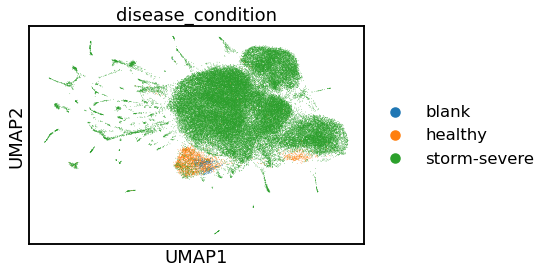

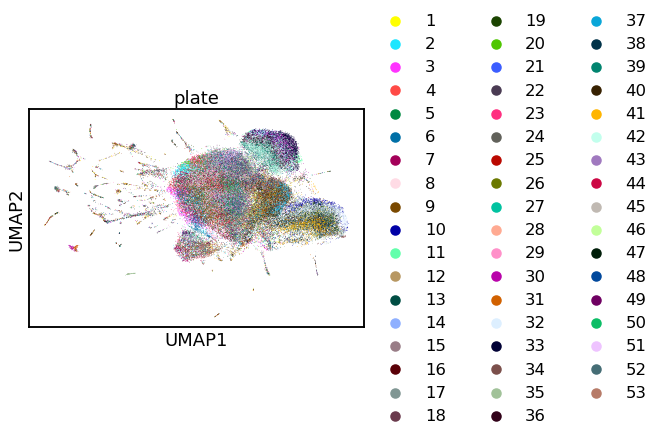

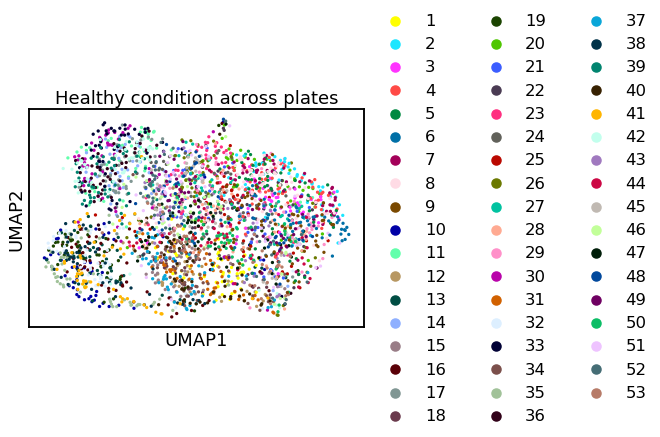

In [30]:
sc.pl.umap(adata, color="disease_condition")
sc.pl.umap(adata, color="plate")
sc.pl.umap(healthy, color=["plate"], title = "Healthy condition across plates")

<b> After harmony integration: <b>

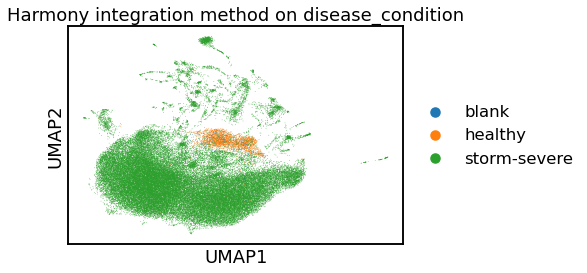

In [21]:
sc.pp.neighbors(harmony, n_neighbors=15, use_rep = "X_emb")
sc.tl.umap(harmony)
sc.pl.umap(harmony, color= "disease_condition", title = "Harmony integration method on disease_condition")

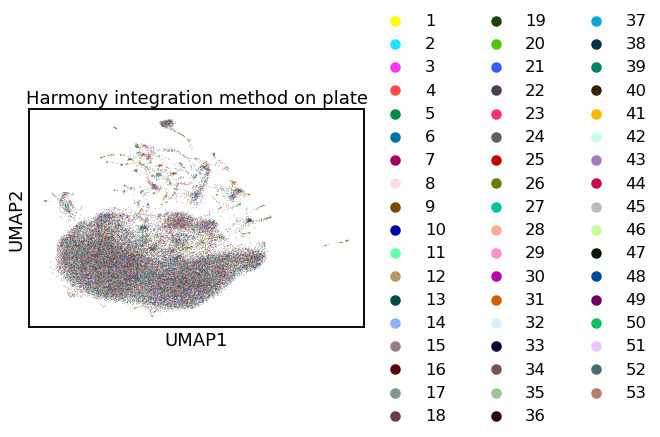

In [11]:
sc.pp.neighbors(harmony, n_neighbors=15, use_rep = "X_emb")
sc.tl.umap(harmony)
sc.pl.umap(harmony, color= "plate", title = "Harmony integration method on plate")

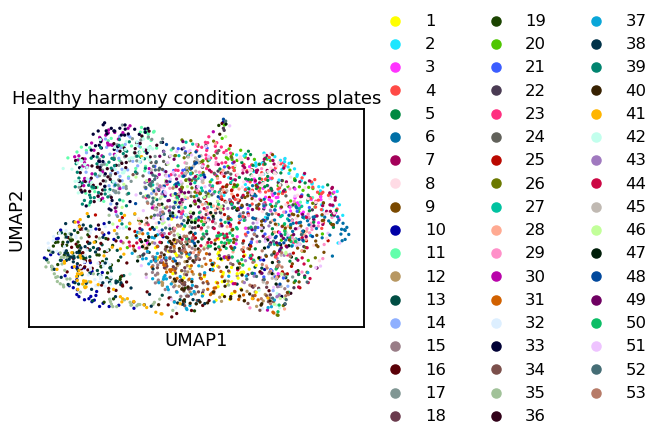

In [12]:
healthy_harmony = harmony[harmony.obs["disease_condition"] == "healthy"]
sc.pp.neighbors(healthy_harmony, n_neighbors=15, use_rep = "X")
sc.tl.umap(healthy_harmony)
sc.pl.umap(healthy_harmony, color=["plate"], title = "Healthy harmony condition across plates")

We can see that after harmony integration, the UMAP nicely clusters both healthy subclusters into once cluster. Also, when looking at the plates, we can now hardly make out any clustering on the big cluster anymore. We can hardly make out any batch correction within the "healthy" condition across plates.

In [22]:
harmony.write_h5ad(
    "rxrx19b_harmony.h5ad",
    compression="gzip"
)

### C. Scanorama: Compute scIB metrics <a class="anchor" id="after_sub3"></a>

#### i. Batch correction metrics <a class="anchor" id="scIB_sub1"></a>

In [9]:
#Graph connectivity
sc.pp.neighbors(scanorama, n_neighbors=15, use_rep = "X")
gc = scib.me.graph_connectivity(scanorama, label_key="disease_condition")

In [10]:
#iLISI
ilisi = scib.me.ilisi_graph(scanorama, batch_key="plate", type_="knn")

In [11]:
#principal component regression, computes PCA if not provided: 
pcr_nc = scib.me.pcr(scanorama, covariate="plate")

In [12]:
#silhouette batch 
#only takes a slot in .obsm as input, i.e. embedding or pca -> compute PCA 
sc.pp.pca(scanorama, n_comps = 100)
silhouette_batch = scib.me.silhouette_batch(scanorama, batch_key="plate", label_key="disease_condition", embed="X_emb")

mean silhouette per group:               silhouette_score
group                         
healthy               0.933666
storm-severe          0.932672


#### ii. Biological conservation metrics <a class="anchor" id="scIB_sub2"></a>

In [13]:
# Calculate cLISI graph
clisi = scib.me.clisi_graph(scanorama, label_key="disease_condition", type_="knn")

In [14]:
#silhouette biological
silhouette = scib.me.silhouette(scanorama, label_key="disease_condition", embed="X_emb")

In [15]:
#NMI
# cluster_optimal_resolution uses precomputed knn if use_rep == None
nmi = scib.metrics.cluster_optimal_resolution(scanorama, label_key = "disease_condition",cluster_key = "cluster", metric = scib.me.nmi, return_all = True)[1]

resolution: 0.1, nmi: 0.136987095390054
resolution: 0.2, nmi: 0.10336216227075837
resolution: 0.3, nmi: 0.09828667380708235
resolution: 0.4, nmi: 0.09787066625170185
resolution: 0.5, nmi: 0.10606034997264967
resolution: 0.6, nmi: 0.09895568492485461
resolution: 0.7, nmi: 0.09617341360219664
resolution: 0.8, nmi: 0.0982034768460144
resolution: 0.9, nmi: 0.10247160484771141
resolution: 1.0, nmi: 0.09827729643996033
resolution: 1.1, nmi: 0.09838402394814735
resolution: 1.2, nmi: 0.09681699944066782
resolution: 1.3, nmi: 0.09399070887987815
resolution: 1.4, nmi: 0.09171923510735346
resolution: 1.5, nmi: 0.09193267268238203
resolution: 1.6, nmi: 0.08929420052176765
resolution: 1.7, nmi: 0.08729419377315407
resolution: 1.8, nmi: 0.08681061332327751
resolution: 1.9, nmi: 0.08558333530376978
resolution: 2.0, nmi: 0.0858378141748591
optimised clustering against disease_condition
optimal cluster resolution: 0.1
optimal score: 0.136987095390054


In [16]:
#ARI
# cluster_optimal_resolution uses precomputed knn if use_rep == None
ari = scib.metrics.cluster_optimal_resolution(scanorama, label_key = "disease_condition",cluster_key = "cluster", metric = scib.me.ari, return_all = True)[1]

resolution: 0.1, ari: 0.10782063110247943
resolution: 0.2, ari: 0.042251775370395116
resolution: 0.3, ari: 0.03899757091755912
resolution: 0.4, ari: 0.038405026988974134
resolution: 0.5, ari: 0.027020559448775693
resolution: 0.6, ari: 0.021461621594496667
resolution: 0.7, ari: 0.020159738966668696
resolution: 0.8, ari: 0.01959585857824115
resolution: 0.9, ari: 0.018477436116592257
resolution: 1.0, ari: 0.016730330549684633
resolution: 1.1, ari: 0.01548610411755124
resolution: 1.2, ari: 0.01400847262593541
resolution: 1.3, ari: 0.012513789426561605
resolution: 1.4, ari: 0.01075923138127734
resolution: 1.5, ari: 0.011178556378229733
resolution: 1.6, ari: 0.009824465552271799
resolution: 1.7, ari: 0.008775844979233513
resolution: 1.8, ari: 0.008533020379554024
resolution: 1.9, ari: 0.00809815118704158
resolution: 2.0, ari: 0.008096254921289396
optimised clustering against disease_condition
optimal cluster resolution: 0.1
optimal score: 0.10782063110247943


In [17]:
#Isolated label score F1
isolated_label_F1 = scib.me.isolated_labels_f1(scanorama, batch_key="plate", label_key="disease_condition", embed = "X_emb")

isolated labels: no more than 1 batches per label
Compute neighbors on rep X_emb
blank: 0.1794960303762513


In [18]:
#Isolated label score ASW
isolated_label_ASW = scib.me.isolated_labels_asw(scanorama, batch_key="plate", label_key="disease_condition", embed="X_emb")

isolated labels: no more than 1 batches per label
blank: 0.5692735512223037


#### iii. Have a look at result <a class="anchor" id="scIB_sub3"></a>
Unintegrated results

1. Batch correction metrics

In [19]:
scanorama_metrics = pd.DataFrame({"Scanorama: Batch correction metrics": []})

scanorama_metrics.loc["Graph_Conn"] = gc
scanorama_metrics.loc["iLISI"] = ilisi
scanorama_metrics.loc["PCR_NC"] = pcr_nc
scanorama_metrics.loc["PCR_Comparison"] = None
scanorama_metrics.loc["Silhouette_batch"] = silhouette_batch

scanorama_metrics

,Scanorama: Batch correction metrics
Graph_Conn,0.990294
iLISI,0.113700
PCR_NC,0.159607
PCR_Comparison,NaN
Silhouette_batch,0.933169


2. Biological conservation metrics

In [27]:
scanorama_metrics_1 = pd.DataFrame({"Scanorama: biol. conservation metrics": []})

scanorama_metrics_1.loc["cLISI"] = clisi
scanorama_metrics_1.loc["Silhouette"] = silhouette
scanorama_metrics_1.loc["NMI"] = nmi
scanorama_metrics_1.loc["ARI"] = ari
scanorama_metrics_1.loc["Isolated_label_F1"] = isolated_label_F1
scanorama_metrics_1.loc["Isolated_label_ASW"] = isolated_label_ASW

scanorama_metrics_1

,Scanorama: biol. conservation metrics
cLISI,1.000000
Silhouette,0.557304
NMI,0.136987
ARI,0.107821
Isolated_label_F1,0.179496
Isolated_label_ASW,0.569274


### D. Scanorama: Before and after UMAP visualization <a class="anchor" id="after_sub4"></a>

<b> After scanorama integration: <b>

In [32]:
sc.pp.neighbors(scanorama, n_neighbors=15, use_rep = "X_pca")
sc.tl.umap(scanorama)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


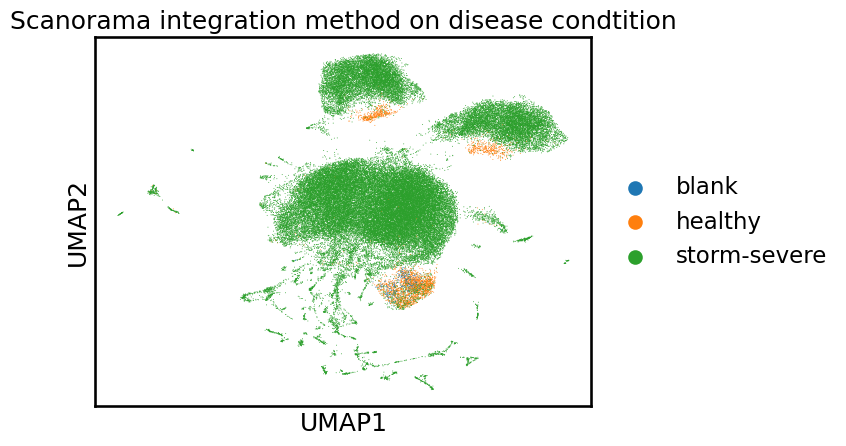

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


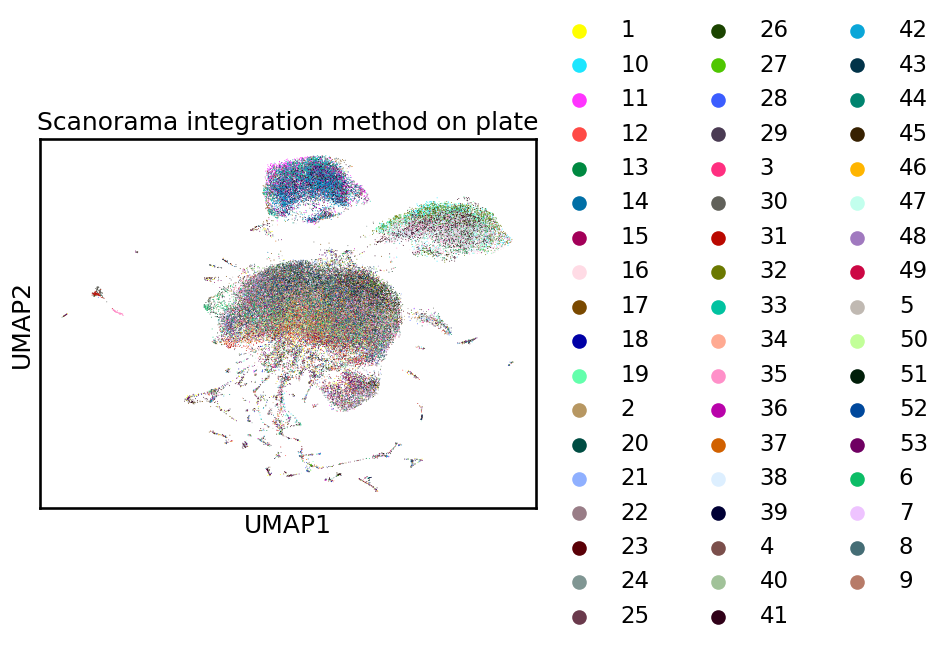

In [33]:
sc.pl.umap(scanorama, color= "disease_condition", title = "Scanorama integration method on disease condtition")
sc.pl.umap(scanorama, color= "plate", title = "Scanorama integration method on plate")

In [34]:
scanorama.write_h5ad(
    "rxrx19b_scanorama.h5ad",
    compression="gzip"
)

### E. scVI: Compute scIB metrics <a class="anchor" id="after_sub5"></a>

#### i. Batch correction metrics <a class="anchor" id="scIB_sub1"></a>

In [8]:
#Graph connectivity
sc.pp.neighbors(scVI, n_neighbors=15, use_rep = "X")
gc = scib.me.graph_connectivity(scVI, label_key="disease_condition")

In [9]:
#iLISI
ilisi = scib.me.ilisi_graph(scVI, batch_key="plate", type_="knn")

In [10]:
#principal component regression, computes PCA if not provided: 
pcr_nc = scib.me.pcr(scVI, covariate="plate")

In [11]:
#silhouette batch 
#only takes a slot in .obsm as input, i.e. embedding or pca -> compute PCA 
sc.pp.pca(scVI, n_comps = 100)
silhouette_batch = scib.me.silhouette_batch(scVI, batch_key="plate", label_key="disease_condition", embed="X_emb")

mean silhouette per group:               silhouette_score
group                         
healthy               0.807377
storm-severe          0.705077


#### ii. Biological conservation metrics <a class="anchor" id="scIB_sub2"></a>

In [12]:
# Calculate cLISI graph
clisi = scib.me.clisi_graph(scVI, label_key="disease_condition", type_="knn")

In [13]:
#silhouette biological
silhouette = scib.me.silhouette(scVI, label_key="disease_condition", embed="X_emb")

In [14]:
#NMI
# cluster_optimal_resolution uses precomputed knn if use_rep == None
nmi = scib.metrics.cluster_optimal_resolution(scVI, label_key = "disease_condition", cluster_key = "cluster", metric = scib.me.nmi, return_all = True)[1]

resolution: 0.1, nmi: 0.17322465164875434
resolution: 0.2, nmi: 0.13577623847607528
resolution: 0.3, nmi: 0.10816945008005008
resolution: 0.4, nmi: 0.10639325028071007
resolution: 0.5, nmi: 0.11046528008549708
resolution: 0.6, nmi: 0.10235834356812273
resolution: 0.7, nmi: 0.100730593508684
resolution: 0.8, nmi: 0.09867050022512093
resolution: 0.9, nmi: 0.10246029685881478
resolution: 1.0, nmi: 0.09860710608651835
resolution: 1.1, nmi: 0.09512597118580444
resolution: 1.2, nmi: 0.08891657279121168
resolution: 1.3, nmi: 0.09075617988336748
resolution: 1.4, nmi: 0.08697872352258974
resolution: 1.5, nmi: 0.08573365520998173
resolution: 1.6, nmi: 0.08332135917775345
resolution: 1.7, nmi: 0.0829443592369907
resolution: 1.8, nmi: 0.08246793055511208
resolution: 1.9, nmi: 0.08146432481398512
resolution: 2.0, nmi: 0.07976449665952465
optimised clustering against disease_condition
optimal cluster resolution: 0.1
optimal score: 0.17322465164875434


In [15]:
#ARI
# cluster_optimal_resolution uses precomputed knn if use_rep == None
ari = scib.metrics.cluster_optimal_resolution(scVI, label_key = "disease_condition",cluster_key = "cluster", metric = scib.me.ari, return_all = True)[1]

resolution: 0.1, ari: 0.12484822281747397
resolution: 0.2, ari: 0.06324413545886493
resolution: 0.3, ari: 0.03029892280407697
resolution: 0.4, ari: 0.027725576327495078
resolution: 0.5, ari: 0.022867487575439615
resolution: 0.6, ari: 0.017175092104810136
resolution: 0.7, ari: 0.01645209984755243
resolution: 0.8, ari: 0.01554894571856156
resolution: 0.9, ari: 0.016345402179553856
resolution: 1.0, ari: 0.013905956586000159
resolution: 1.1, ari: 0.012521883571360281
resolution: 1.2, ari: 0.009558300112373734
resolution: 1.3, ari: 0.01019812957138881
resolution: 1.4, ari: 0.008450721419674402
resolution: 1.5, ari: 0.007964821792424899
resolution: 1.6, ari: 0.006599876905990698
resolution: 1.7, ari: 0.0064217973973720276
resolution: 1.8, ari: 0.006167576238512411
resolution: 1.9, ari: 0.005978927001941377
resolution: 2.0, ari: 0.005388355728059098
optimised clustering against disease_condition
optimal cluster resolution: 0.1
optimal score: 0.12484822281747397


In [16]:
#Isolated label score F1
isolated_label_F1 = scib.me.isolated_labels_f1(scVI, batch_key="plate", label_key="disease_condition", embed = "X_emb")

isolated labels: no more than 1 batches per label
Compute neighbors on rep X_emb
blank: 0.09161290322580645


In [17]:
#Isolated label score ASW
isolated_label_ASW = scib.me.isolated_labels_asw(scVI, batch_key="plate", label_key="disease_condition", embed="X_emb")

isolated labels: no more than 1 batches per label
blank: 0.6096988990902901


#### iii. Have a look at result <a class="anchor" id="scIB_sub3"></a>
Unintegrated results

1. Batch correction metrics

In [18]:
scVI_metrics = pd.DataFrame({"scVI: Batch correction metrics": []})

scVI_metrics.loc["Graph_Conn"] = gc
scVI_metrics.loc["iLISI"] = ilisi
scVI_metrics.loc["PCR_NC"] = pcr_nc
scVI_metrics.loc["PCR_Comparison"] = None
scVI_metrics.loc["Silhouette_batch"] = silhouette_batch

scVI_metrics

,scVI: Batch correction metrics
Graph_Conn,0.995068
iLISI,0.076297
PCR_NC,0.164878
PCR_Comparison,NaN
Silhouette_batch,0.756227


2. Biological conservation metrics

In [19]:
scVI_metrics_1 = pd.DataFrame({"scVI: biol. conservation metrics": []})

scVI_metrics_1.loc["cLISI"] = clisi
scVI_metrics_1.loc["Silhouette"] = silhouette
scVI_metrics_1.loc["NMI"] = nmi
scVI_metrics_1.loc["ARI"] = ari
scVI_metrics_1.loc["Isolated_label_F1"] = isolated_label_F1
scVI_metrics_1.loc["Isolated_label_ASW"] = isolated_label_ASW

scVI_metrics_1

,scVI: biol. conservation metrics
cLISI,1.000000
Silhouette,0.253296
NMI,0.173225
ARI,0.124848
Isolated_label_F1,0.091613
Isolated_label_ASW,0.609699


### F. scVI: Before and after UMAP visualization <a class="anchor" id="after_sub6"></a>

<b> After scVI integration: <b>

In [20]:
sc.pp.neighbors(scVI, n_neighbors=15, use_rep = "X_pca")
sc.tl.umap(scVI)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


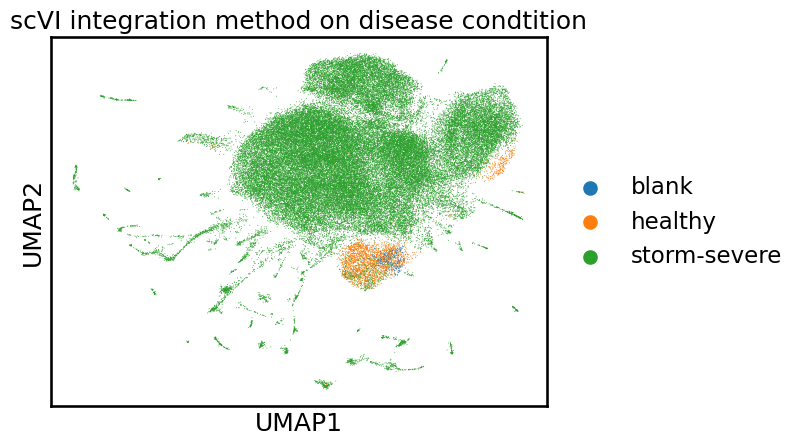

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


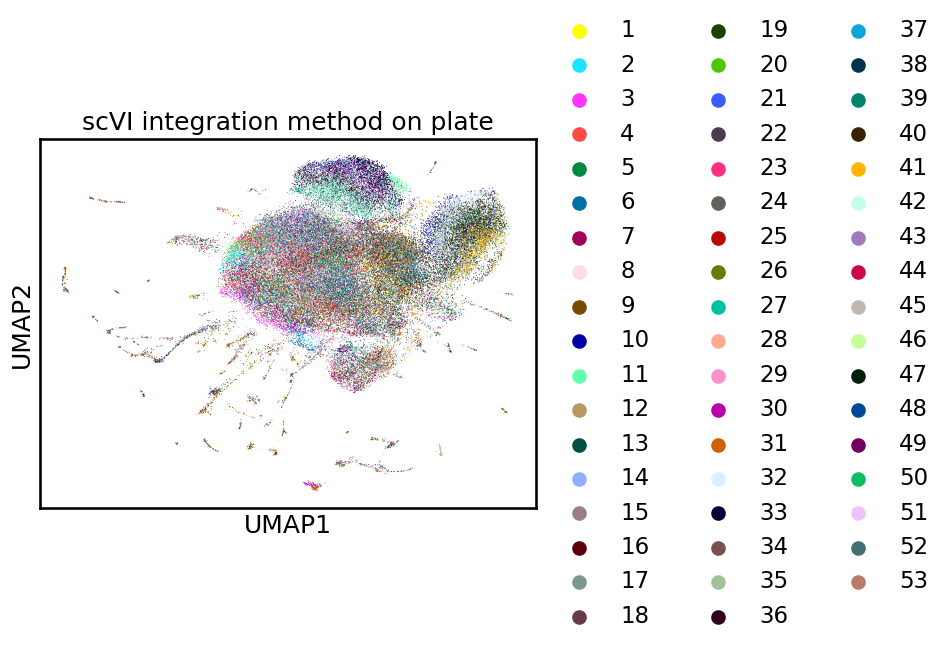

In [21]:
sc.pl.umap(scVI, color= "disease_condition", title = "scVI integration method on disease condtition")
sc.pl.umap(scVI, color= "plate", title = "scVI integration method on plate")

In [22]:
scVI.write_h5ad(
    "rxrx19b_scVI.h5ad",
    compression="gzip"
)

### G. scanVI: Compute scIB metrics <a class="anchor" id="after_sub7"></a>

#### i. Batch correction metrics <a class="anchor" id="scIB_sub1"></a>

In [25]:
#Graph connectivity
sc.pp.neighbors(scANVI, n_neighbors=15, use_rep = "X")
gc = scib.me.graph_connectivity(scANVI, label_key="disease_condition")

In [26]:
#iLISI
ilisi = scib.me.ilisi_graph(scANVI, batch_key="plate", type_="knn")

In [27]:
#principal component regression, computes PCA if not provided: 
pcr_nc = scib.me.pcr(scANVI, covariate="plate")

In [28]:
#silhouette batch 
#only takes a slot in .obsm as input, i.e. embedding or pca -> compute PCA 
sc.pp.pca(scANVI, n_comps = 100)
silhouette_batch = scib.me.silhouette_batch(scANVI, batch_key="plate", label_key="disease_condition", embed="X_emb")

mean silhouette per group:               silhouette_score
group                         
healthy               0.743866
storm-severe          0.804125


#### ii. Biological conservation metrics <a class="anchor" id="scIB_sub2"></a>

In [29]:
# Calculate cLISI graph
clisi = scib.me.clisi_graph(scANVI, label_key="disease_condition", type_="knn")

In [30]:
#silhouette biological
silhouette = scib.me.silhouette(scANVI, label_key="disease_condition", embed="X_emb")

In [31]:
#NMI
# cluster_optimal_resolution uses precomputed knn if use_rep == None
nmi = scib.metrics.cluster_optimal_resolution(scANVI, label_key = "disease_condition", cluster_key = "cluster", metric = scib.me.nmi, return_all = True)[1]

resolution: 0.1, nmi: 0.17322465164875434
resolution: 0.2, nmi: 0.13577623847607528
resolution: 0.3, nmi: 0.10816945008005008
resolution: 0.4, nmi: 0.10639325028071007
resolution: 0.5, nmi: 0.11046528008549708
resolution: 0.6, nmi: 0.10235834356812273
resolution: 0.7, nmi: 0.100730593508684
resolution: 0.8, nmi: 0.09867050022512093
resolution: 0.9, nmi: 0.10246029685881478
resolution: 1.0, nmi: 0.09860710608651835
resolution: 1.1, nmi: 0.09512597118580444
resolution: 1.2, nmi: 0.08891657279121168
resolution: 1.3, nmi: 0.09075617988336748
resolution: 1.4, nmi: 0.08697872352258974
resolution: 1.5, nmi: 0.08573365520998173
resolution: 1.6, nmi: 0.08332135917775345
resolution: 1.7, nmi: 0.0829443592369907
resolution: 1.8, nmi: 0.08246793055511208
resolution: 1.9, nmi: 0.08146432481398512
resolution: 2.0, nmi: 0.07976449665952465
optimised clustering against disease_condition
optimal cluster resolution: 0.1
optimal score: 0.17322465164875434


In [32]:
#ARI
# cluster_optimal_resolution uses precomputed knn if use_rep == None
ari = scib.metrics.cluster_optimal_resolution(scANVI, label_key = "disease_condition",cluster_key = "cluster", metric = scib.me.ari, return_all = True)[1]

resolution: 0.1, ari: 0.12484822281747397
resolution: 0.2, ari: 0.06324413545886493
resolution: 0.3, ari: 0.03029892280407697
resolution: 0.4, ari: 0.027725576327495078
resolution: 0.5, ari: 0.022867487575439615
resolution: 0.6, ari: 0.017175092104810136
resolution: 0.7, ari: 0.01645209984755243
resolution: 0.8, ari: 0.01554894571856156
resolution: 0.9, ari: 0.016345402179553856
resolution: 1.0, ari: 0.013905956586000159
resolution: 1.1, ari: 0.012521883571360281
resolution: 1.2, ari: 0.009558300112373734
resolution: 1.3, ari: 0.01019812957138881
resolution: 1.4, ari: 0.008450721419674402
resolution: 1.5, ari: 0.007964821792424899
resolution: 1.6, ari: 0.006599876905990698
resolution: 1.7, ari: 0.0064217973973720276
resolution: 1.8, ari: 0.006167576238512411
resolution: 1.9, ari: 0.005978927001941377
resolution: 2.0, ari: 0.005388355728059098
optimised clustering against disease_condition
optimal cluster resolution: 0.1
optimal score: 0.12484822281747397


In [33]:
#Isolated label score F1
isolated_label_F1 = scib.me.isolated_labels_f1(scANVI, batch_key="plate", label_key="disease_condition", embed = "X_emb")

isolated labels: no more than 1 batches per label
Compute neighbors on rep X_emb
blank: 0.19145569620253167


In [34]:
#Isolated label score ASW
isolated_label_ASW = scib.me.isolated_labels_asw(scANVI, batch_key="plate", label_key="disease_condition", embed="X_emb")

isolated labels: no more than 1 batches per label
blank: 0.49501877184957266


#### iii. Have a look at result <a class="anchor" id="scIB_sub3"></a>
Unintegrated results

1. Batch correction metrics

In [35]:
scANVI_metrics = pd.DataFrame({"scANVI: Batch correction metrics": []})

scANVI_metrics.loc["Graph_Conn"] = gc
scANVI_metrics.loc["iLISI"] = ilisi
scANVI_metrics.loc["PCR_NC"] = pcr_nc
scANVI_metrics.loc["PCR_Comparison"] = None
scANVI_metrics.loc["Silhouette_batch"] = silhouette_batch

scANVI_metrics

,scANVI: Batch correction metrics
Graph_Conn,0.995068
iLISI,0.076297
PCR_NC,0.164878
PCR_Comparison,NaN
Silhouette_batch,0.773995


2. Biological conservation metrics

In [36]:
scANVI_metrics_1 = pd.DataFrame({"scANVI: biol. conservation metrics": []})

scANVI_metrics_1.loc["cLISI"] = clisi
scANVI_metrics_1.loc["Silhouette"] = silhouette
scANVI_metrics_1.loc["NMI"] = nmi
scANVI_metrics_1.loc["ARI"] = ari
scANVI_metrics_1.loc["Isolated_label_F1"] = isolated_label_F1
scANVI_metrics_1.loc["Isolated_label_ASW"] = isolated_label_ASW

scANVI_metrics_1

,scANVI: biol. conservation metrics
cLISI,1.000000
Silhouette,0.857728
NMI,0.173225
ARI,0.124848
Isolated_label_F1,0.191456
Isolated_label_ASW,0.495019


### H. scANVI: Before and after UMAP visualization <a class="anchor" id="after_sub8"></a>

<b> After scANVI integration: <b>

In [37]:
sc.pp.neighbors(scANVI, n_neighbors=15, use_rep = "X_pca")
sc.tl.umap(scANVI)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


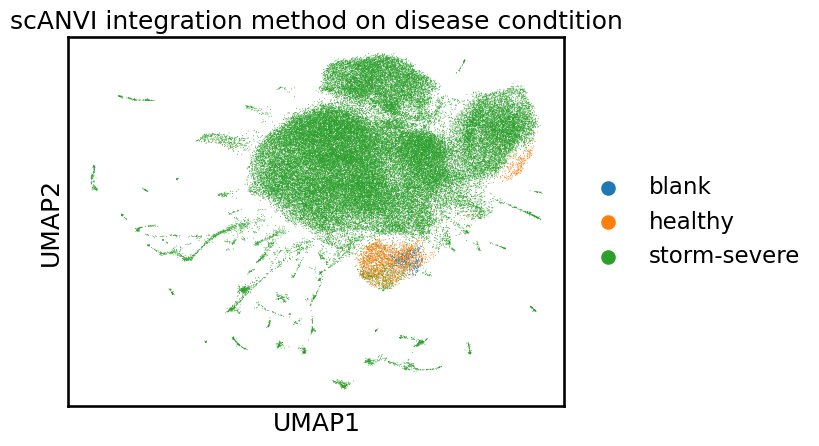

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


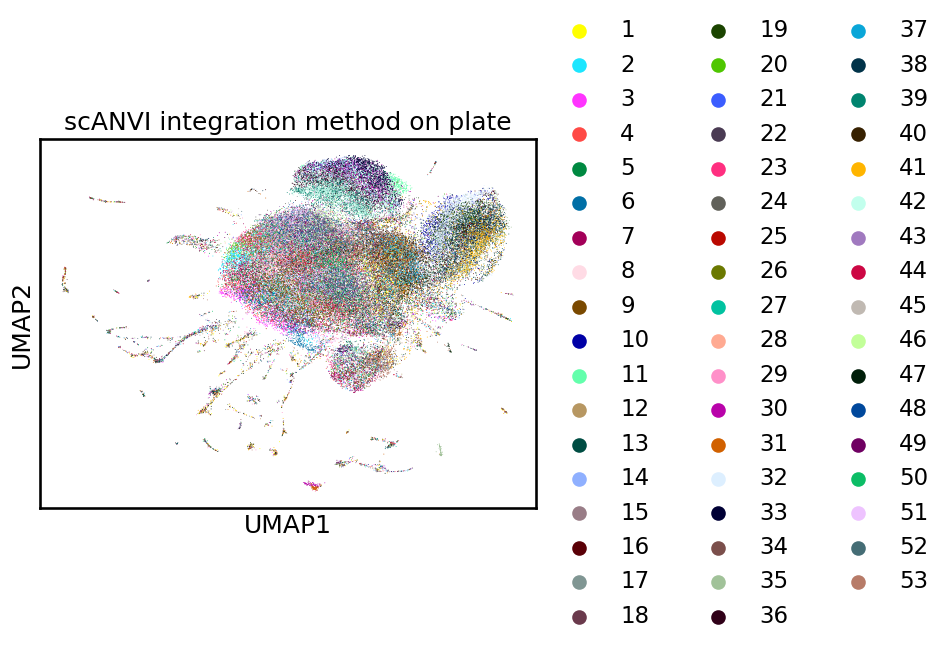

In [38]:
sc.pl.umap(scANVI, color= "disease_condition", title = "scANVI integration method on disease condtition")
sc.pl.umap(scANVI, color= "plate", title = "scANVI integration method on plate")

We note that scVI and scANVI are very similar.

In [39]:
scANVI.write_h5ad(
    "rxrx19b_scANVI.h5ad",
    compression="gzip"
)

### I. scGen: Compute scIB metrics <a class="anchor" id="after_sub9"></a>

#### i. Batch correction metrics <a class="anchor" id="scIB_sub1"></a>

In [3]:
#Graph connectivity
sc.pp.neighbors(scGen, n_neighbors=15, use_rep = "X")
gc = scib.me.graph_connectivity(scGen, label_key="disease_condition")

In [4]:
#iLISI
ilisi = scib.me.ilisi_graph(scGen, batch_key="plate", type_="knn")

In [5]:
#principal component regression, computes PCA if not provided: 
pcr_nc = scib.me.pcr(scGen, covariate="plate")

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:447: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


In [6]:
#silhouette batch 
#only takes a slot in .obsm as input, i.e. embedding or pca -> compute PCA 
sc.pp.pca(scGen, n_comps = 100)
silhouette_batch = scib.me.silhouette_batch(scGen, batch_key="plate", label_key="disease_condition", embed="corrected_latent")

mean silhouette per group:               silhouette_score
group                         
healthy               0.860270
storm-severe          0.963948


#### ii. Biological conservation metrics <a class="anchor" id="scIB_sub2"></a>

In [7]:
# Calculate cLISI graph
clisi = scib.me.clisi_graph(scGen, label_key="disease_condition", type_="knn")

In [8]:
#silhouette biological
silhouette = scib.me.silhouette(scGen, label_key="disease_condition", embed="corrected_latent")

In [9]:
#NMI
# cluster_optimal_resolution uses precomputed knn if use_rep == None
nmi = scib.metrics.cluster_optimal_resolution(scGen, label_key = "disease_condition",cluster_key = "cluster", metric = scib.me.nmi, return_all = True)[1]

resolution: 0.1, nmi: 0.35504461146420346
resolution: 0.2, nmi: 0.16956226856548326
resolution: 0.3, nmi: 0.1344606689712049
resolution: 0.4, nmi: 0.13154884681623874
resolution: 0.5, nmi: 0.10692743038247776
resolution: 0.6, nmi: 0.10662675813555114
resolution: 0.7, nmi: 0.10085351234135073
resolution: 0.8, nmi: 0.09616429134308956
resolution: 0.9, nmi: 0.09566225870556523
resolution: 1.0, nmi: 0.09296443571091573
resolution: 1.1, nmi: 0.08858248834038784
resolution: 1.2, nmi: 0.08711347981156144
resolution: 1.3, nmi: 0.08570044185629837
resolution: 1.4, nmi: 0.08619558703388425
resolution: 1.5, nmi: 0.08218806354924549
resolution: 1.6, nmi: 0.08213899544099347
resolution: 1.7, nmi: 0.07984591622898769
resolution: 1.8, nmi: 0.07732836066142866
resolution: 1.9, nmi: 0.07731086981688395
resolution: 2.0, nmi: 0.07664031196224697
optimised clustering against disease_condition
optimal cluster resolution: 0.1
optimal score: 0.35504461146420346


In [10]:
#ARI
# cluster_optimal_resolution uses precomputed knn if use_rep == None
ari = scib.metrics.cluster_optimal_resolution(scGen, label_key = "disease_condition",cluster_key = "cluster", metric = scib.me.ari, return_all = True)[1]

resolution: 0.1, ari: 0.45345827093763774
resolution: 0.2, ari: 0.12139024724457559
resolution: 0.3, ari: 0.06227467330015029
resolution: 0.4, ari: 0.05430314730221938
resolution: 0.5, ari: 0.027923744160462328
resolution: 0.6, ari: 0.026560675238174996
resolution: 0.7, ari: 0.022406809167762377
resolution: 0.8, ari: 0.018244239843863377
resolution: 0.9, ari: 0.01776443350413356
resolution: 1.0, ari: 0.01654683667925358
resolution: 1.1, ari: 0.0140485202455292
resolution: 1.2, ari: 0.012143924902766128
resolution: 1.3, ari: 0.011288637485101833
resolution: 1.4, ari: 0.01109412402859661
resolution: 1.5, ari: 0.009353509515692013
resolution: 1.6, ari: 0.0086748268541147
resolution: 1.7, ari: 0.007547301381168306
resolution: 1.8, ari: 0.006070204649920666
resolution: 1.9, ari: 0.006077964831095247
resolution: 2.0, ari: 0.005443938586709413
optimised clustering against disease_condition
optimal cluster resolution: 0.1
optimal score: 0.45345827093763774


In [11]:
#Isolated label score F1
isolated_label_F1 = scib.me.isolated_labels_f1(scGen, batch_key="plate", label_key="disease_condition", embed = "corrected_latent")

isolated labels: no more than 1 batches per label
Compute neighbors on rep corrected_latent
blank: 0.12136953955135775


In [12]:
#Isolated label score ASW
isolated_label_ASW = scib.me.isolated_labels_asw(scGen, batch_key="plate", label_key="disease_condition", embed="corrected_latent")

isolated labels: no more than 1 batches per label
blank: 0.6215426400303841


#### iii. Have a look at result <a class="anchor" id="scIB_sub3"></a>
Unintegrated results

1. Batch correction metrics

In [13]:
scGen_metrics = pd.DataFrame({"scGen: Batch correction metrics": []})

scGen_metrics.loc["Graph_Conn"] = gc
scGen_metrics.loc["iLISI"] = ilisi
scGen_metrics.loc["PCR_NC"] = pcr_nc
scGen_metrics.loc["PCR_Comparison"] = None
scGen_metrics.loc["Silhouette_batch"] = silhouette_batch

scGen_metrics

/tmp/ipykernel_510706/3797051708.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  scGen_metrics.loc["PCR_Comparison"] = None


,scGen: Batch correction metrics
Graph_Conn,0.991755
iLISI,0.182343
PCR_NC,0.005657
PCR_Comparison,NaN
Silhouette_batch,0.912109


2. Biological conservation metrics

In [14]:
scGen_metrics_1 = pd.DataFrame({"scGen: biol. conservation metrics": []})

scGen_metrics_1.loc["cLISI"] = clisi
scGen_metrics_1.loc["Silhouette"] = silhouette
scGen_metrics_1.loc["NMI"] = nmi
scGen_metrics_1.loc["ARI"] = ari
scGen_metrics_1.loc["Isolated_label_F1"] = isolated_label_F1
scGen_metrics_1.loc["Isolated_label_ASW"] = isolated_label_ASW

scGen_metrics_1

,scGen: biol. conservation metrics
cLISI,1.000000
Silhouette,0.521271
NMI,0.355045
ARI,0.453458
Isolated_label_F1,0.121370
Isolated_label_ASW,0.621543


### J. scGen: Before and after UMAP visualization <a class="anchor" id="after_sub10"></a>

<b> After scGen integration: <b>

In [15]:
sc.pp.neighbors(scGen, n_neighbors=15, use_rep = "corrected_latent")
sc.tl.umap(scGen)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


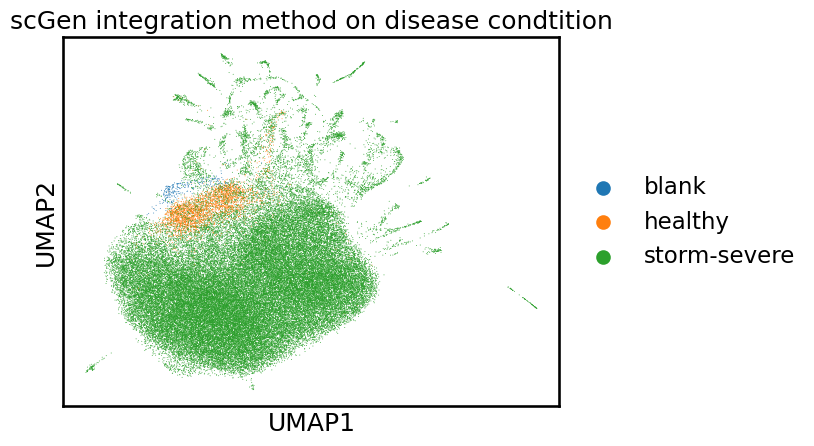

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


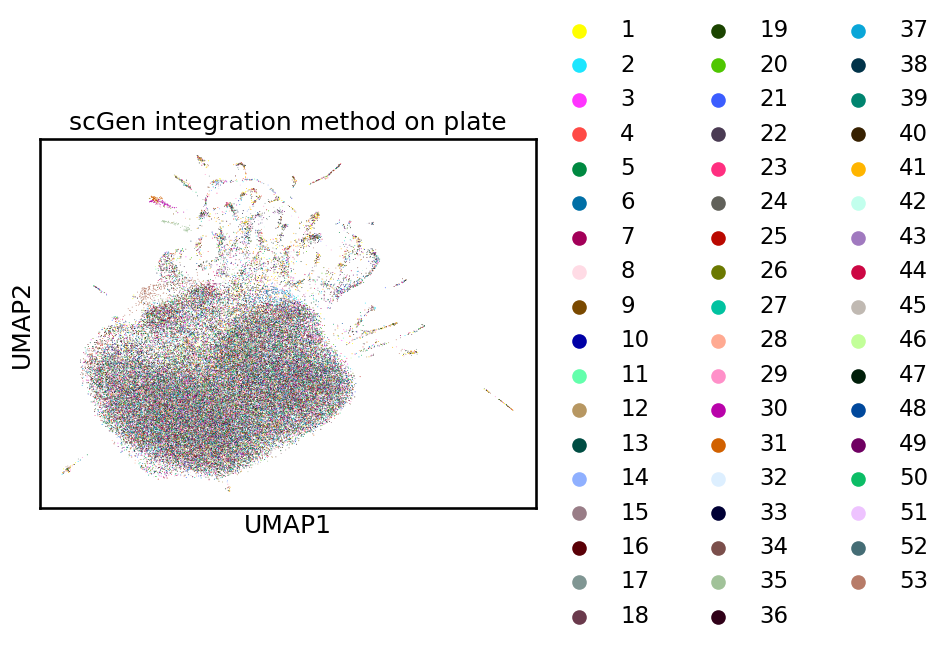

In [16]:
sc.pl.umap(scGen, color= "disease_condition", title = "scGen integration method on disease condtition")
sc.pl.umap(scGen, color= "plate", title = "scGen integration method on plate")

We realize that scGen performs very well regarding removing "plate" as batch effect while preserving biology "disease_condition".

In [17]:
scGen.write_h5ad(
    "rxrx19b_scGen.h5ad",
    compression="gzip"
)